# DL development pipeline

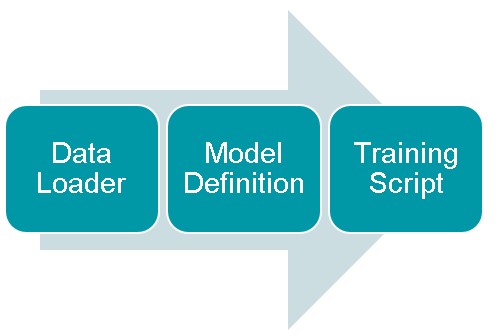

In [ ]:
# !pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
def get_sequential_model(input_shape): 
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),
            
            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),           
            
            # Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    
    return model
    

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames= [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'Abyssinian_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name']. \
                          isin(invalid_filenames)]
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
csv_path = '/content/drive/MyDrive/data/kfolds.csv'

train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128, 
    image_size=256,
    shuffle=True
)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128, 
    image_size=256,
    shuffle=True
)

# Callback functions

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1,
    mode='min', restore_best_weights=False
)

In [8]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='min', min_Ir=0.001
)

In [9]:
filepath = '{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val-loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

# 훈련 진행

In [15]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=2, # 훈련시간이 많이 소요되는 관계로 epochs = 10 -> 2로 조정 
    callbacks=[
        early_stopping,
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose=1
)

Epoch 1/2
46/46 [==============================] - 5134s 112s/step - loss: 0.6158 - accuracy: 0.6782 - val_loss: 0.6358 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 2/2
46/46 [==============================] - 5162s 112s/step - loss: 0.6113 - accuracy: 0.6708 - val_loss: 0.6426 - val_accuracy: 0.6787 - lr: 0.0010


In [16]:
history.history

{'accuracy': [0.678243100643158, 0.6707524657249451],
 'loss': [0.615841805934906, 0.61126309633255],
 'lr': [0.001, 0.001],
 'val_accuracy': [0.6773315072059631, 0.6786929965019226],
 'val_loss': [0.6358311176300049, 0.6426287889480591]}

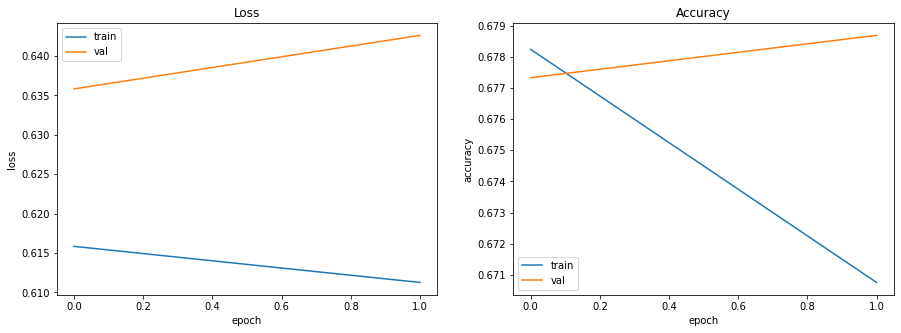

In [17]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()